In [1]:
# Imports
from os import makedirs
from os.path import join
import joblib
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.auto import tqdm
import pandas as pd

from sklearn.model_selection import ParameterGrid
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, fcluster

from umap import UMAP
import plotly.offline as pyo
pyo.init_notebook_mode()

# Directory constants
analysis_of_embeddings_dir = ".."
analysis_of_embeddings_data_dir = join(analysis_of_embeddings_dir, "data")
analysis_of_embeddings_custom_data_dir = join(analysis_of_embeddings_dir, "custom_data")
root_code_dir = join(analysis_of_embeddings_dir, "..")
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")

# Extend sys path for importing custom Python files
import sys
sys.path.extend([analysis_of_embeddings_dir, root_code_dir])

from utils import get_model_checkpoint_filepaths, pairwise_cosine_distances
from analysis_utils import (agglomerative_clustering,
                            agglomerative_cluster_hyperparameter_search, plot_cluster_metric_scores,
                            words_in_clusters, plot_cluster_sizes, inspect_word_clusters,
                            load_word_cluster_group_words, visualize_word_cluster_groups)
from word_embeddings.eval_utils import plot_word_vectors
from word_embeddings.word2vec import load_model_training_output

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-1817cd933c7d>", line 21, in <module>
    from umap import UMAP
  File "/usr/local/lib/python3.6/dist-packages/umap/__init__.py", line 1, in <module>
    from .umap_ import UMAP
  File "/usr/local/lib/python3.6/dist-packages/umap/umap_.py", line 62, in <module>
    from pynndescent import NNDescent
  File "/usr/local/lib/python3.6/dist-packages/pynndescent/__init__.py", line 3, in <module>
    from .pynndescent_ import NNDescent, PyNNDescentTransformer
  File "/usr/local/lib/python3.6/dist-packages/pynndescent/pynndescent_.py", line 21, in <module>
    import pynndescent.sparse as sparse
  File "/usr/local/lib/python3.6/dist-packages/pynndescent/sparse.py", line 222, in <module>
    "i": numba.types.uint16,
  File "/usr/local/lib/python3.6/dist-packages/numba/core/decorat

TypeError: object of type 'NoneType' has no len()

# Prepare data

In [ ]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(word2vec_training_dir, "word2vec_enwiki_sept_2020_word2phrase"),
    model_name="word2vec",
    dataset_name="enwiki",
)
last_embedding_weights = w2v_training_output["last_embedding_weights"]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]

In [ ]:
# Restrict vocabulary size for analysis
vocab_size = 10000

In [ ]:
# Precompute cosine distance matrix
word_embeddings_to_precompute = last_embedding_weights[:vocab_size]
word_embeddings_distances = pairwise_cosine_distances(word_embeddings_to_precompute)

# Clustering

In [ ]:
# Perform agglomerative clustering
agglomerative_clusterings = agglomerative_clustering(
    word_embeddings_pairwise_dists=word_embeddings_distances,
    linkages=["complete", "average", "single"]
)

In [ ]:
should_pred_cluster_labels = False
ks = [2, 3, 4, 5, 10, 50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
if should_pred_cluster_labels:
    pred_cluster_labels = agglomerative_cluster_hyperparameter_search(
        cluster_numbers=ks,
        linkages=list(agglomerative_clusterings.keys()),
        agglomerative_clusterings=agglomerative_clusterings,
        word_embeddings=word_embeddings_to_precompute,
        word_embeddings_pairwise_dists=word_embeddings_distances,
        output_dir=word2vec_cluster_analysis_dir,
        model_name="word2vec",
        dataset_name="enwiki",
        output_filepath_suffix="agglomerative_labels",
    )
else:
    pred_cluster_labels = joblib.load(
        join(word2vec_cluster_analysis_dir, "word2vec-enwiki-agglomerative_labels.joblib")
    )

In [7]:
#fig, axes_rows = plt.subplots(nrows=3, cols=2, figsize=(8 * 2, 6 * 3))
#for linkage, axes_cols in zip(agglomerative_clusterings.keys(), axes_rows):
#    print(f"Linkage: {linkage}")
#    for metric, ax in zip(pred_cluster_labels[linkage]["metrics"].values(), axes_cols):
#        plot_cluster_metric_scores(
#            metric_scores=metric["scores"],
#            hyperparameters=[{"n_clusters": k} for k in ks],
#            best_score_idx=metric["best_score_idx"],
#            metric_name=metric["name"],
#            ax=ax
#        )

Linkage: complete


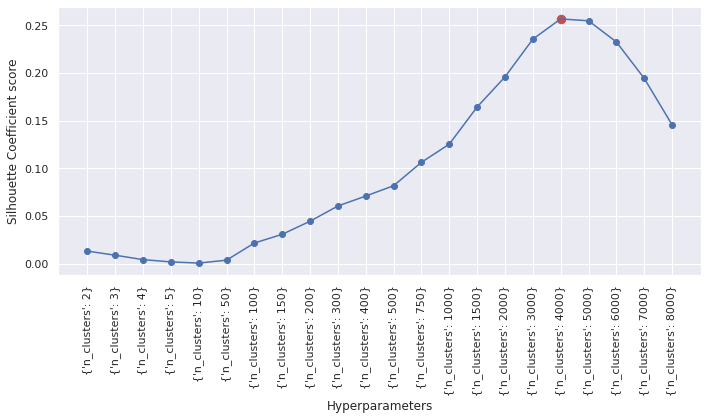

Linkage: average


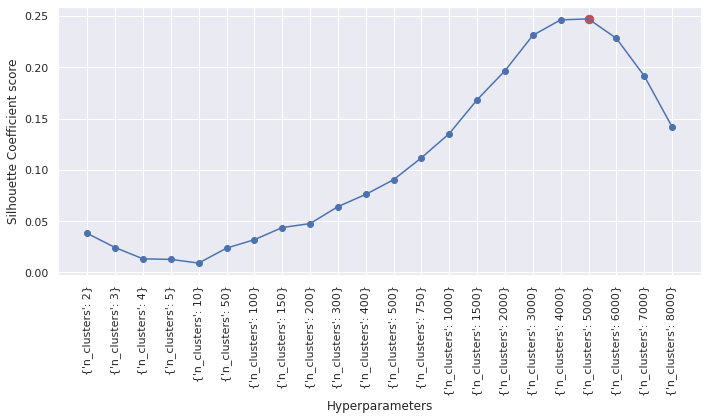

Linkage: single


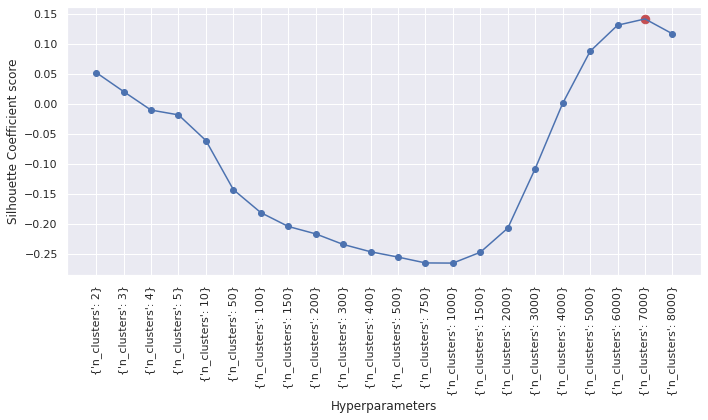

In [8]:
for linkage in agglomerative_clusterings.keys():
    print(f"Linkage: {linkage}")
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_cluster_metric_scores(
        metric_scores=pred_cluster_labels[linkage]["metric_scores"],
        hyperparameters=[{"n_clusters": k} for k in ks],
        best_score_idx=pred_cluster_labels[linkage]["best_cluster_labels_idx"],
        metric_name=pred_cluster_labels[linkage]["metric_name"],
        ax=ax
    )

**Observation**: single linkage clustering does not seem to yield any good results looking at the silhouette score (lots of negative scores) and we will discard it from the further analysis.

In [9]:
# Zoom in at 3000-6000 clusters, discarding single linkage clustering.
should_pred_cluster_labels_zoomed = False
start_zoom_cluster_num = 3000
end_zoom_cluster_num = 6000
ks_zoomed = np.arange(start_zoom_cluster_num, end_zoom_cluster_num + 1) # np.linspace(3000, 6000, num=100, dtype=int)
if should_pred_cluster_labels_zoomed:
    pred_cluster_labels_zoomed = agglomerative_cluster_hyperparameter_search(
        cluster_numbers=ks_zoomed,
        linkages=["complete", "average"],
        agglomerative_clusterings=agglomerative_clusterings,
        word_embeddings_pairwise_dists=word_embeddings_distances,
        output_dir=word2vec_cluster_analysis_dir,
        model_name="word2vec",
        dataset_name="enwiki",
        output_filepath_suffix="agglomerative_labels_zoomed",
    )
else:
    pred_cluster_labels_zoomed = joblib.load(
        join(word2vec_cluster_analysis_dir, "word2vec-enwiki-agglomerative_labels_zoomed.joblib")
    )

Linkage: complete
Best number of clusters: 4287


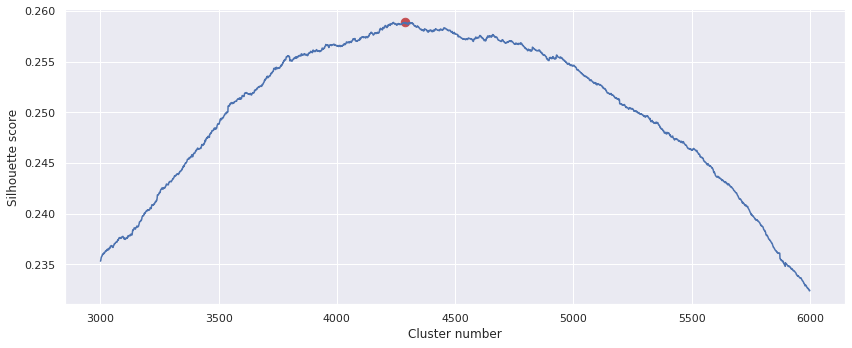

Linkage: average
Best number of clusters: 4463


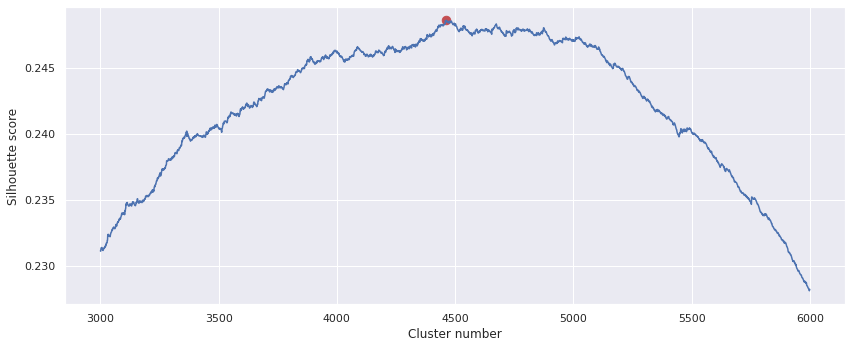

In [10]:
best_cluster_labels = {}
for linkage in ["complete", "average"]:
    print(f"Linkage: {linkage}")
    silhouette_scores = pred_cluster_labels_zoomed[linkage]["metric_scores"]
    best_cluster_labels_idx = pred_cluster_labels_zoomed[linkage]["best_cluster_labels_idx"]
    
    best_num_clusters = ks_zoomed[best_cluster_labels_idx]
    print(f"Best number of clusters: {best_num_clusters}")
    
    best_cluster_labels[linkage] = pred_cluster_labels_zoomed[linkage]["cluster_labels"][best_cluster_labels_idx]
    
    fig, ax = plt.subplots(figsize=(12, 5))
    plot_cluster_metric_scores(
        hyperparameters=[{"n_clusters": k} for k in ks_zoomed],
        metric_scores=silhouette_scores,
        best_score_idx=best_cluster_labels_idx,
        metric_name="Silhouette",
        scatter=False,
        set_xticks=False,
        ax=ax,
        xlabel="Cluster number",
        xrange=ks_zoomed
    )

Complete linkage clustering yields the highest silhouette score. For this reason, we choose this linkage for the cluster analysis.

In [11]:
chosen_cluster_labels = best_cluster_labels["complete"]

# Cluster analysis

4287 clusters: max=35, min=1, ratio=35.0


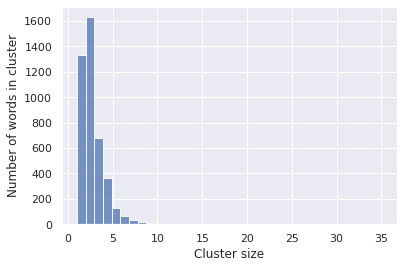

In [12]:
# Plot cluster sizes
most_common_cluster_sizes = plot_cluster_sizes(chosen_cluster_labels)

In [13]:
# Inspect word clusters
inspect_word_clusters(
    cluster_labels=chosen_cluster_labels,
    words=words[:vocab_size],
    min_cluster_size=5,
    most_common_cluster_sizes=most_common_cluster_sizes,
    num_words_in_clusters_print=10,
)

-- 10 largest clusters --
['forty-five' 'sixty-four' 'sixty-five' 'thirty-five' 'forty-four'
 'sixty-eight' 'forty-two' 'thirty-two' 'forty-eight' 'sixty-seven'
 'sixty-six' 'forty-one' 'sixty-nine' 'fifty-five' 'thirty-six'
 'sixty-two' 'sixty-three' 'thirty-three' 'thirty-nine' 'thirty-eight'
 'forty-seven' 'sixty-one' 'forty-six' 'thirty-seven' 'forty-three'
 'forty-nine' 'fifty-six' 'fifty-two' 'thirty-four' 'fifty-four'
 'fifty-one' 'fifty-eight' 'fifty-nine' 'fifty-seven' 'fifty-three']
['thousand' 'one' 'hundred' 'nine' 'ninety' 'ninety-nine' 'ninety-eight'
 'ninety-five' 'ninety-six' 'ninety-seven' 'ninety-two' 'ninety-four'
 'ninety-three' 'seventy-five' 'ninety-one' 'eighty-nine' 'eighty-five'
 'eighty-eight' 'eighty-six' 'eighty-seven' 'eighty-four' 'eighty-three'
 'eighty-two' 'seventy-two' 'eighty-one' 'seventy-six' 'seventy-nine'
 'seventy-eight' 'seventy-four' 'seventy-seven' 'seventy-one'
 'seventy-three']
['two' 'eight' 'three' 'four' 'five' 'six' 'seven' 'ten' 'twelve